### Procedurally generated worlds using Pandas and Numpy
I'm a big fan of rouge-like games and RPGs. I'm also a big fan of data science tools for Python. This is my attempt to have it all. Because these notebooks call from modules used in the live game, I also use them for dev / testing. If something is crashing in the game I can simulate it here to see what is wrong and test out new features before dropping them in the production code. 

In the live game there are three stages of creation:
* The age of **elements** - building terrain
* The age of **mortals** - adding cities and nations
* The age of **conflict** - random events that shift the relationships between nations, towns and people.

Currently only 1 and 2 are shown here. 


In [1]:
import pandas as pd
import numpy as np
import pickle

import altair as alt

#importing local libraries for drawings (because they clutter)
#I'm mapping to the actual files in the repo so that I can also use this to troubleshoot
import sys, os, yaml
sys.path.append('../')
sys.path.append('../../')

import lib.drawMaps as draw


In [2]:
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'prodweb.settings')
django.setup()
from lib.builders import world as w, landscape as l
from lib.builders import people,towns,nations, events,culture as c


There are default parameters that I've chosen as the best fit for creating a _ 'believable' _ world. You can experiment with those variables by editing them here. They won't affect the production parameters. 


In [3]:
l.default_params

{'grid': [40, 40], 'N_loc': 0, 'N_std': 1, 'water_level': 20}

In [4]:
landscape = l.Landscape()
landscape

I'm going to use the `landscape` over and over to specify the world's parameters. Some of the parameters are set by the user and some of them are hard cast. 

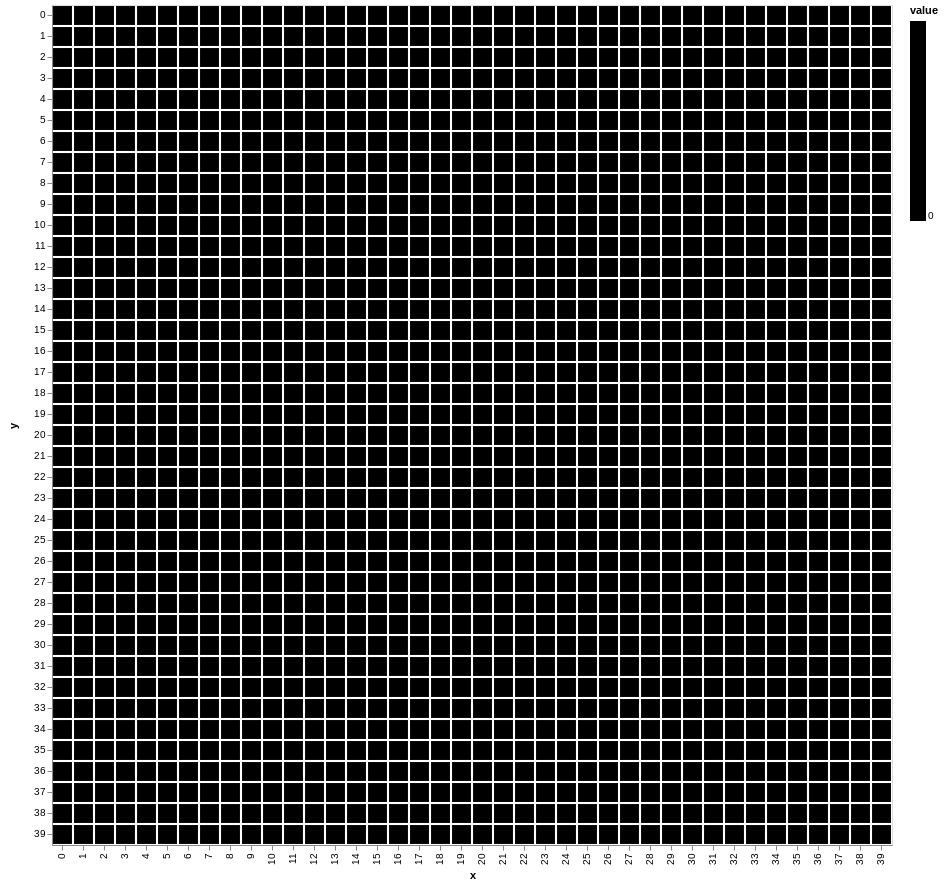

In [5]:
world = w.World(landscape)
draw.drawTerrainHeight(world.grid_elevation)

# in the beginning, the world was void and without form.

Starting with a grid with nothing on it. No elevation, no terrain. All of this will be generated procedurally. 

You can see here that the terrain is shifted on a random-normal distribution to make it look _uneven_. Making it randomly doesn't make it look _real_ so I'm going to have to be smarter about the rules that raise and lower terrain in order to make them look like mountains. 

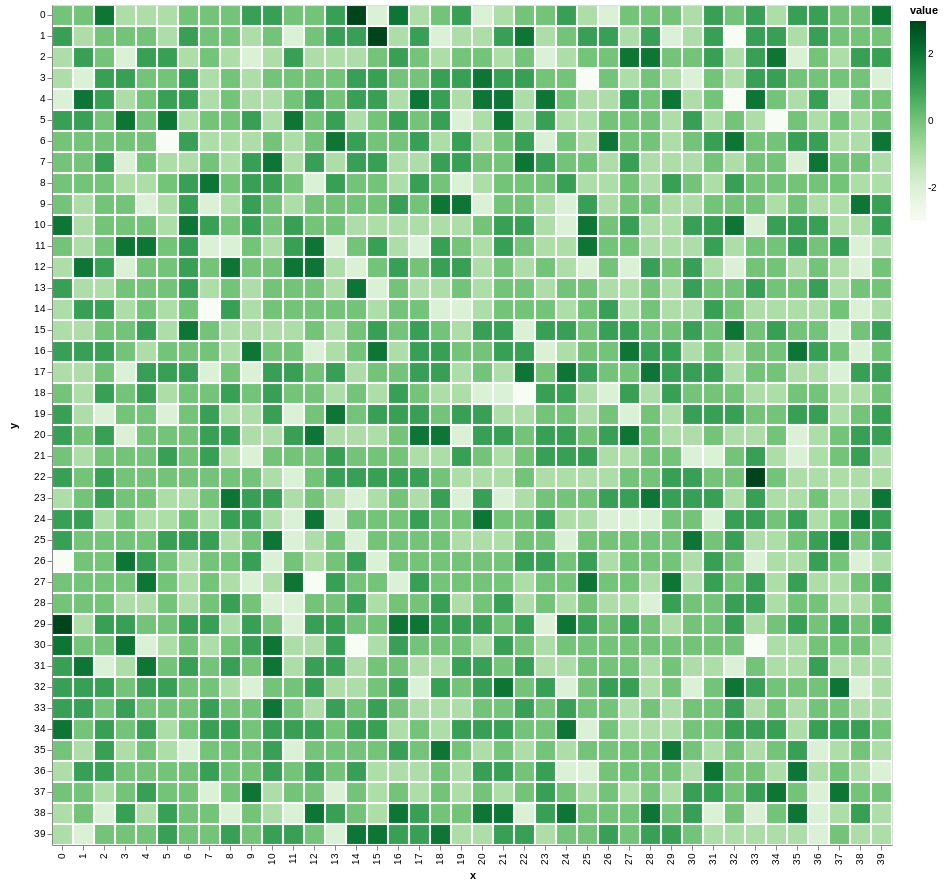

In [6]:
world.shift_terrain()
draw.drawTerrainHeight(world.grid_elevation)

Just random terrain shifting won't make anything like real terrain types. 

# Mountains formed

Using Np.pad to build a pyramid, I'm making something that looks much more like a mountain. This is just a single mountain. 

In [7]:
world.getMountain()

,0,1,2
0,1,1,1
1,1,2,1
2,1,1,1


This is great, but I need to place the mountain on a random place on the terrain. Currently just drop the edges of the mountain if they go off the grid. I might wrap them around later. **Note** height needs to be odd in order to draw symmetrically.

In [8]:
coord = world.get_random_chord()
m = world.getMountain(height=5)
print("Mountain Placed: ", coord)

mdf = world.reindexMountain(coord,m)
mdf

Mountain Placed:  [18  4]


,0,1,2,3,4,5,6,7,8
14,1,1,1,1,1,1,1,1,1
15,1,2,2,2,2,2,2,2,1
16,1,2,3,3,3,3,3,2,1
17,1,2,3,4,4,4,3,2,1
18,1,2,3,4,5,4,3,2,1
19,1,2,3,4,4,4,3,2,1
20,1,2,3,3,3,3,3,2,1
21,1,2,2,2,2,2,2,2,1
22,1,1,1,1,1,1,1,1,1


This makes a much more _natural_ looking mountain. 

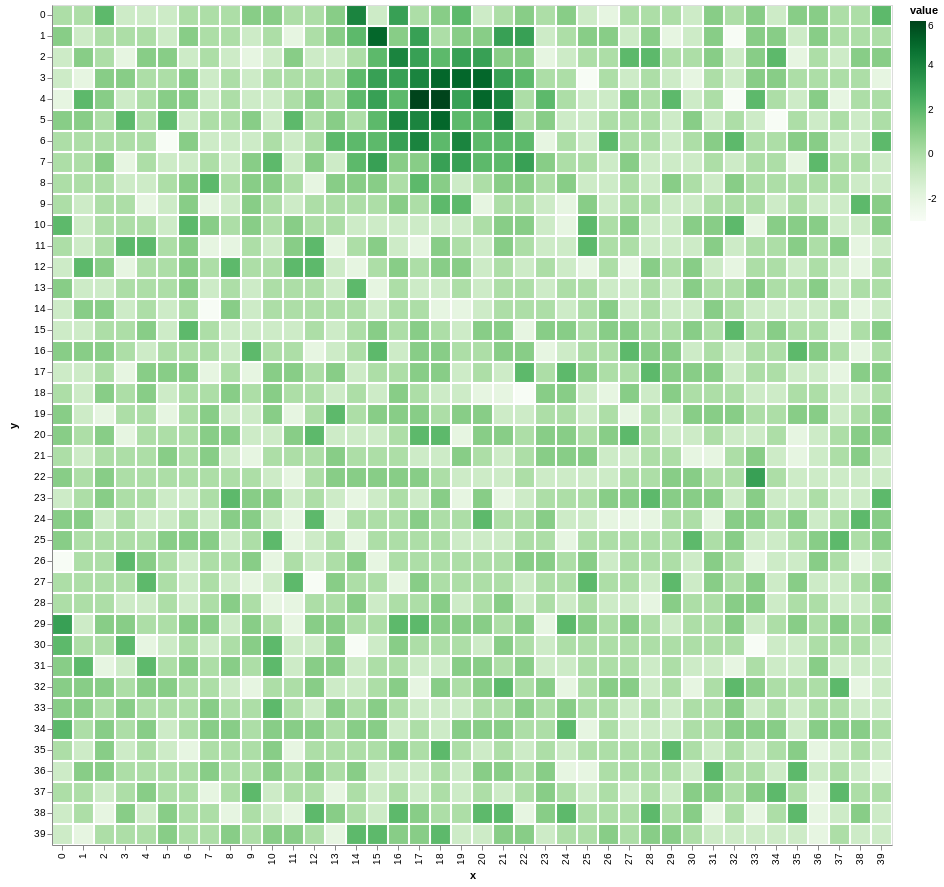

In [9]:
world.add_mountain(mdf)
draw.drawTerrainHeight(world.grid_elevation)

It's a good looking mountain, but I need mountain ranges not dots. In order to drag mountains on the board I'll need to create a brownian motion function to drop a mountain and then move. 

In [10]:
world.brownian_land()

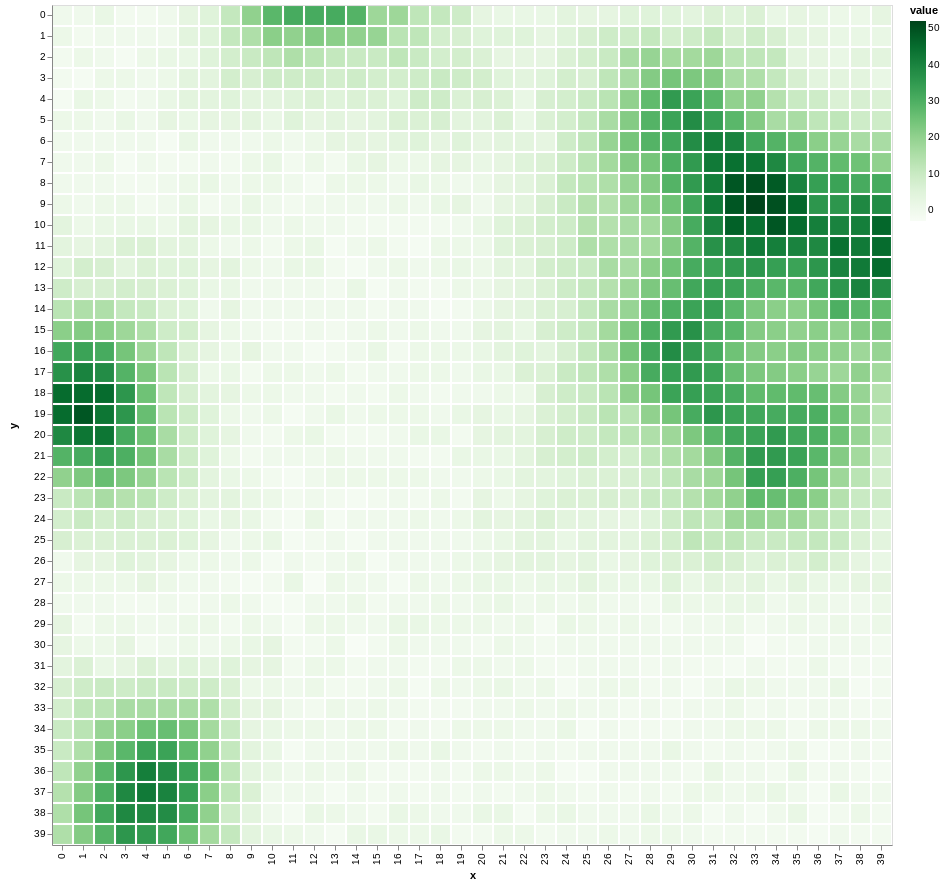

In [11]:
draw.drawTerrainHeight(world.grid_elevation)

Now that's starting to look like land. The shapes come out really map-like. Compute time is lower than my previous version as well. Only drawing the Altair viz takes time. 

## Oceans

If the oceans were to come in at `height == 0` then you can assume that lower terrain is _under water_

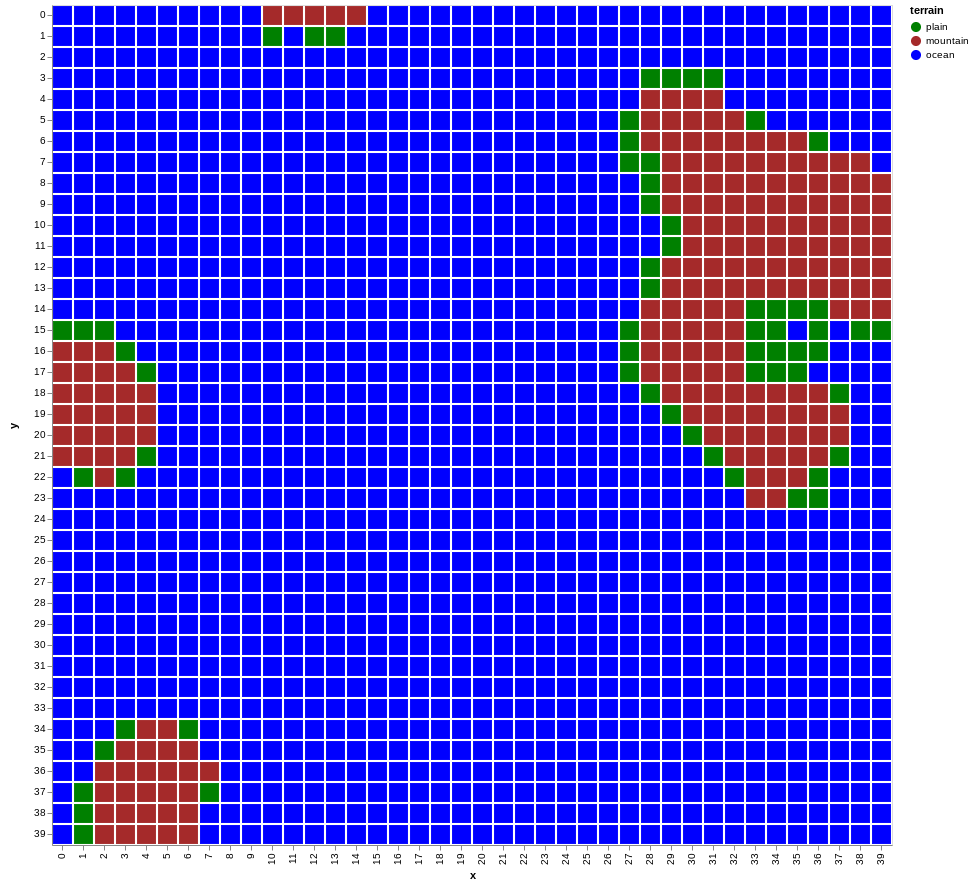

In [12]:
draw.drawTerrainTypes(world.grid_elevation,world.landscape)

### Rainfall

Rainfall makes terrain different. Wet areas become forests. Dry areas become deserts. 

In [13]:
world.brownian_rainfall()

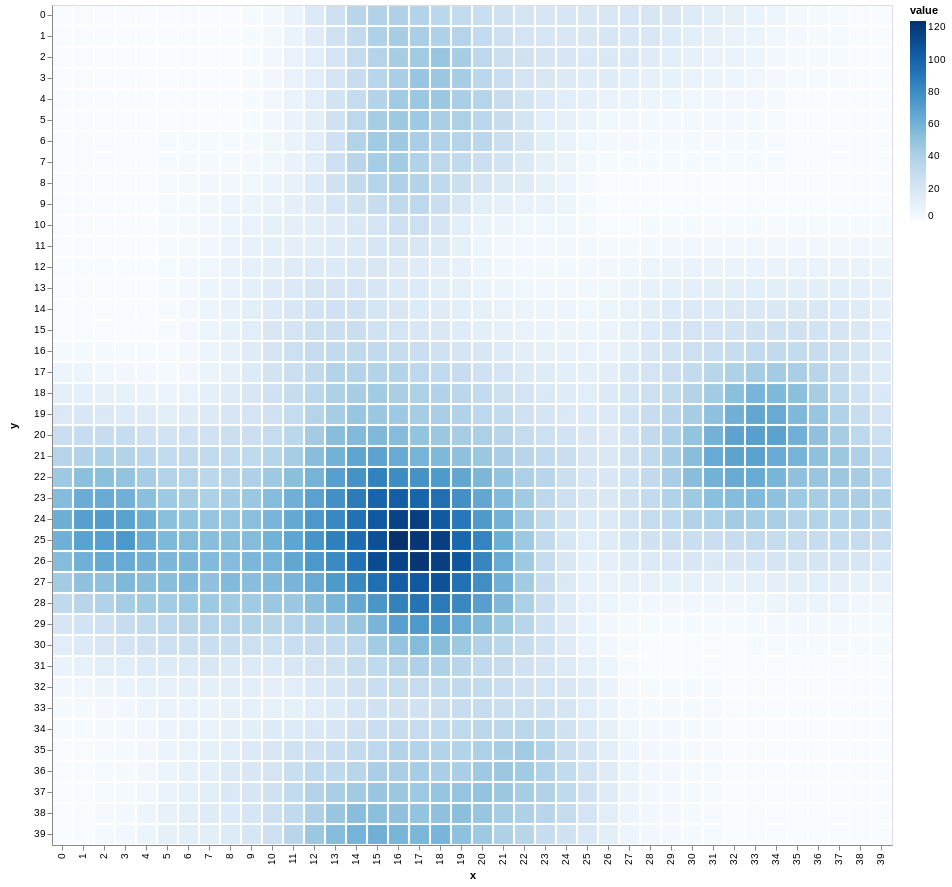

In [14]:
draw.drawRainFall(world.grid_rainfall)

### Build core game features dataframe
This function builds the df_features that will be used later in the actual game. This way you can quickly search and filter the world to find things.

In [15]:
world.build_df_features()

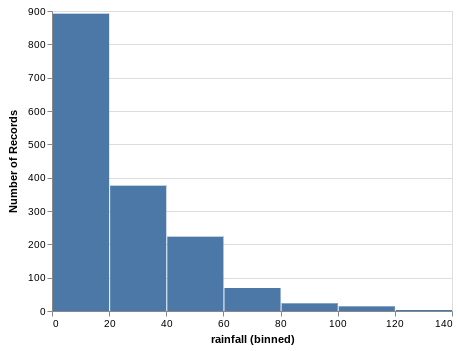

In [16]:
alt.Chart(world.df_features).mark_bar().encode(
    alt.X("rainfall", bin=True),
    y='count()',
)

The amount of rainfal in the world determines if the area will become a forest or a desert. This can be set from the `landscape` parameters. 

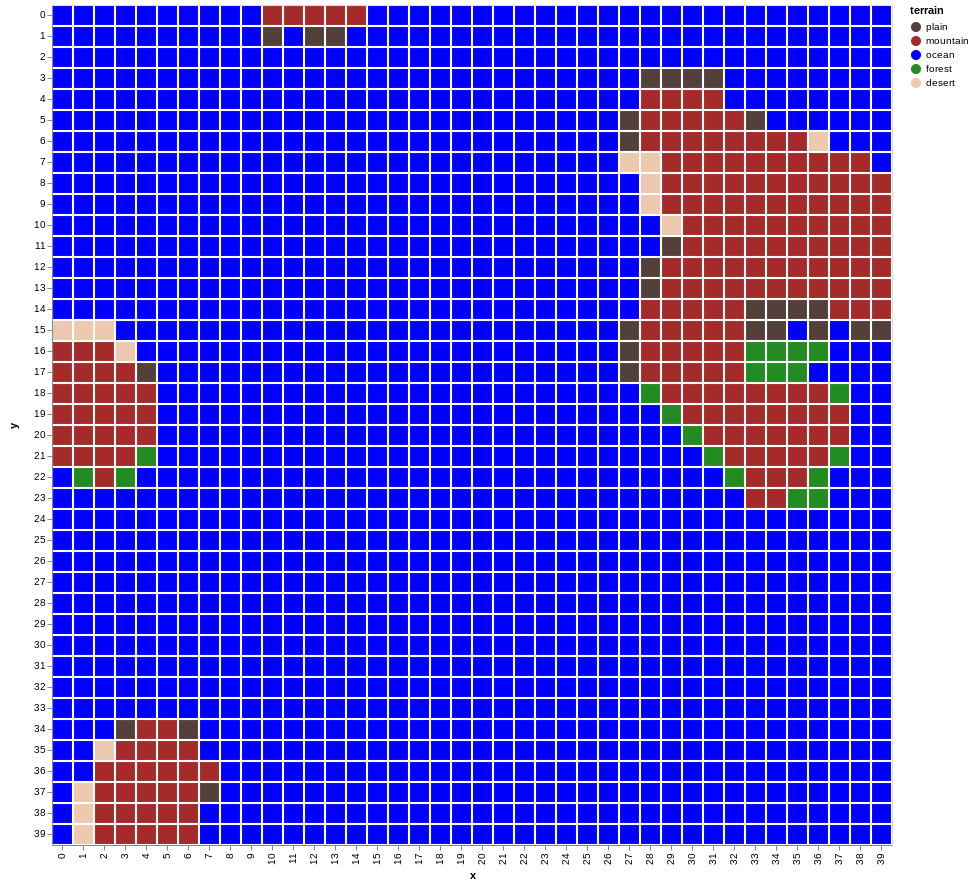

In [17]:
world.df_features['terrain'] = world.df_features.apply(lambda x: w.set_ecology(x,landscape),axis =1 )
draw.drawterrainadvanced(world.df_features)

# The age of the Mortals

The terrain and all of the natural features are formed in the first age. Mountains, rivers, lakes and forests. Once the land has settled, the first cities appear. 

Culture settings come from the user input, there are defaults for everything. Once specified the `.culture` placeholder can be replaced. It should not be used until this point. 


In [18]:
c

<module 'lib.builders.culture' from '../lib/builders/culture.py'>

In [19]:
# the path to the `datasets` folder is different when launched in the Notebook.
culture = c.Culture(paths='notebooks')
world.culture = culture
world.culture.eons

10

## People
A `Person` is a required parameter for many things like `towns`, `nations` and `buildings`

A person requires a `culture` to specify how the names will be generated. As a default the person is a `peon` and exists nowhere (`None`). Optional parameters allow the person to be created with a `role` and a `location`. `Location` can be a `town`, `building` or a `key` where the person can be found. 

In [20]:
people.Person(world.culture,location=world.get_random_chord())

Feshun the commoner

## Towns

the `__init__` method of a city takes a founding age and a location (which can be generated randomly via `World.get_random_chord`). The init method automatically generates a name. The default nation is the name of the town.

In [21]:
new_town = towns.Town(world.get_random_chord(),1,culture,people)
new_town

town of Stormrun: population: 1 location: [3,33] founded 1

In [22]:
new_town.speaker

Sharram the Speaker of Stormrun

## The age of civilization

Cities grow for a set number of aeons. During each eon
* n new villages are born
* each village has g% chance to grow

The cities are randomly placed (not in the ocean)

In [23]:
all_towns = towns.build_towns(world,people)
world.towns = all_towns
[(str(p),p.population) for p in all_towns]

[('town of Ratcombe: population: 2 location: [35,6] founded 0',
  [Quiglust the Speaker of Ratcombe, Hadellab the commoner]),
 ('town of Splitspike: population: 4 location: [3,35] founded 0',
  [Dragrard the Speaker of Splitspike,
   Metallend the commoner,
   Mofaddat the commoner,
   Quitendule the commoner]),
 ('town of Brinehammer: population: 4 location: [32,14] founded 1',
  [Saxodin the Speaker of Brinehammer,
   Kascelle the commoner,
   Ekoyellech the commoner,
   Picarrof the commoner]),
 ('town of Godcatch: population: 4 location: [28,3] founded 1',
  [Alolarkeb the Speaker of Godcatch,
   Hekrule the commoner,
   Soffomir the commoner,
   Thagrort the commoner]),
 ('town of Faircrawl: population: 2 location: [37,14] founded 1',
  [Joyellus the Speaker of Faircrawl, Braklik the commoner]),
 ('town of Snowhollow: population: 3 location: [34,14] founded 1',
  [Chiwillac the Speaker of Snowhollow,
   Elengumber the commoner,
   Bokillud the commoner]),
 ('town of Lordsplace: po

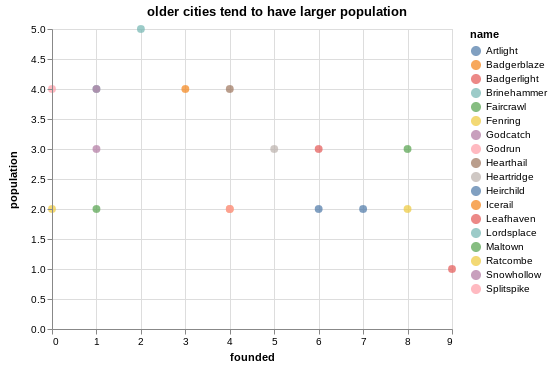

In [24]:
def population_age(towns):
    df = pd.DataFrame(index=range(len(all_towns)))
    df['name'] = [t.name for t in all_towns]
    df['population'] = [t.pop for t in all_towns]
    df['founded'] = [t.founded for t in all_towns]
    return df

alt.Chart(population_age(towns),title="older cities tend to have larger population").mark_circle(size=60).encode(
    y='population',
    x='founded',
    color='name',
    tooltip=['name']
)

## Adding the towns to the map: 
Redrawing the map adds the cities. Note that all cities have a specific age, population. People in those cities have names, occupations and varying levels of loyalty and temperment.

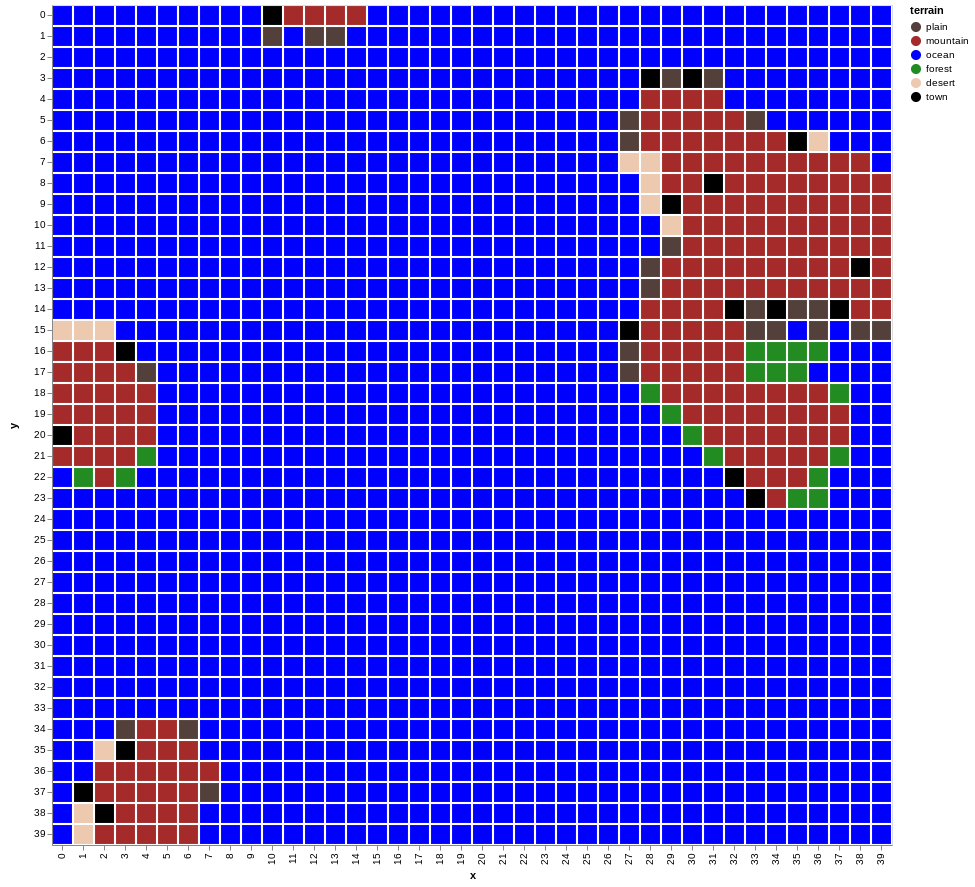

In [25]:
world.add_features(all_towns)
#TODO: Update drawCities to support more terrain types
draw.drawCities(world.df_features)

**Towns** are a __feature__ of the terrain. The terrain determines what `terr_items` and `terr_details` will be in that area, and the __feature__ determines special things for that space.

In [26]:
world.df_features[world.df_features['feature'].isna()==False]

,y,rainfall,x,key,elevation,terrain,feature
key,,,,,,,
10:0,0,3.0,10,10:0,28.0,town,Badgerlight
28:3,3,11.0,28,28:3,22.0,town,Godcatch
30:3,3,9.0,30,30:3,23.0,town,Icerail
35:6,6,0.0,35,35:6,26.0,town,Ratcombe
31:8,8,0.0,31,31:8,41.0,town,Badgerblaze
29:9,9,0.0,29,29:9,25.0,town,Lordsplace
38:12,12,8.0,38,38:12,42.0,town,Hearthail
32:14,14,18.0,32,32:14,28.0,town,Brinehammer
34:14,14,18.0,34,34:14,21.0,town,Snowhollow


# Nations

In [28]:
#k is the actual k_means cluster object.
all_nations,k = nations.cluster_nations(world)
world.nations = all_nations

all_nations

{0: 'Doomring',
 1: 'Servantsring',
 2: 'Coremoral',
 3: 'Stonemark',
 4: 'Fallward',
 5: 'Malring',
 6: 'Hardborourgh',
 7: 'Lionrise'}

Standard Scikit-Learn stuff. I'm using K-means to group the `towns` into `nations` based on proximity.

In [29]:
k

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [29]:
world.df_features = nations.predict_nations(k,world)
world.df_features.head(20)

,y,rainfall,x,key,elevation,terrain,feature,nation number,nation
key,,,,,,,,,
0:0,0,8.0,0,0:0,0.0,ocean,NaN,NaN,NaN
1:0,0,12.0,1,1:0,0.0,ocean,NaN,NaN,NaN
2:0,0,17.0,2,2:0,0.0,ocean,NaN,NaN,NaN
3:0,0,21.0,3,3:0,1.0,ocean,NaN,NaN,NaN
4:0,0,25.0,4,4:0,1.0,ocean,NaN,NaN,NaN
5:0,0,30.0,5,5:0,0.0,ocean,NaN,NaN,NaN
6:0,0,34.0,6,6:0,0.0,ocean,NaN,NaN,NaN
7:0,0,29.0,7,7:0,0.0,ocean,NaN,NaN,NaN
8:0,0,25.0,8,8:0,1.0,ocean,NaN,NaN,NaN


The age of conflict is next, so the starting fealty and diplomacy for each town is 1

In [30]:
for t in all_towns:
    try:
        t.set_starting_fielty(world)
    except:
        continue
        
town = world.towns[1]
print(f"{town.name} is loyal to the nation of {town.nation}")
print(f"{town.diplomacy}")

Foundersbridge is loyal to the nation of Hardmain
{'nation': 'Hardmain', 'national fealty': 1}


In [31]:
#for each nation (n), appoint the most populus city (c) as it's capitol.
for n in np.unique(world.df_features['nation'].dropna()):
    cu = world.df_features[(world.df_features['nation']==n)& \
          (world.df_features['terrain']=='town')]['feature'].tolist()
    #getting the town objects
    ts = [t for t in all_towns if t.name in cu]
    #get population(p)
    p = [t.pop for t in ts]
    #getting the first town that has the max population, make that the capitol
    ts[np.argmax(p)].type='capitol'
    
world.towns

[capitol of Ravenlight: population: 4 location: [13,30] founded 0,
 capitol of Foundersbridge: population: 5 location: [28,28] founded 0,
 town of Lordsspring: population: 3 location: [15,26] founded 0,
 town of Landsloch: population: 3 location: [12,35] founded 1,
 capitol of Magecombe: population: 4 location: [16,37] founded 1,
 capitol of Demonscoil: population: 5 location: [24,32] founded 2,
 town of Godhail: population: 2 location: [33,38] founded 2,
 town of Clearborourgh: population: 5 location: [30,36] founded 2,
 capitol of Lionhollow: population: 1 location: [28,3] founded 3,
 town of Hardlight: population: 2 location: [24,34] founded 4,
 capitol of Heirmark: population: 3 location: [30,34] founded 4,
 town of Rockchild: population: 3 location: [31,30] founded 5,
 capitol of Starhost: population: 2 location: [28,39] founded 5,
 town of Starplace: population: 2 location: [26,30] founded 6,
 town of Brineforth: population: 2 location: [22,34] founded 6,
 town of Helljaw: popula

In [32]:
world.nations = [nations.Nation(n,world,world.culture,people) for n in world.nations.values()]
world.nations

[Nation of Coretear,
 Nation of Hardmain,
 Nation of Magemoral,
 Nation of Snakeford,
 Nation of Oakmore,
 Nation of Landscombe,
 Nation of Lilywish,
 Nation of Warmore]

In [33]:
world.nations[0].towns

[town of Landsloch: population: 3 location: [12,35] founded 1,
 capitol of Magecombe: population: 4 location: [16,37] founded 1]

In [34]:
world.nations[0].get_capitol().population

[Moldren the Speaker of Magecombe,
 Eriladdodin the commoner,
 Orglos the commoner,
 Orpit the commoner,
 Grolarkorb the Ruler of the nation of Coretear]

So the world has nations, nations have towns, and towns have people. Objects all nested together and easy to reference. A nation's capitol will always have two people: the ruler and the speaker. Larger cities will have extra peons. 

In [35]:
world.nations[0].get_capitol().population[0].get_person_data()

{'name': 'Moldren',
 'role': 'Speaker of Magecombe',
 'loyalty': 0.5,
 'temperment': 0.98,
 'attributes': ['alive'],
 'messages': ['Hello stranger.']}

In [36]:
world.df_features[world.df_features['feature'].isna()==False].sort_values(['nation'])

,y,rainfall,x,key,elevation,terrain,feature,nation number,nation
key,,,,,,,,,
16:37,37,7.0,16,16:37,29.0,town,Magecombe,0.0,Coretear
12:35,35,40.0,12,12:35,26.0,town,Landsloch,0.0,Coretear
28:28,28,1.0,28,28:28,28.0,town,Foundersbridge,1.0,Hardmain
26:30,30,0.0,26,26:30,31.0,town,Starplace,1.0,Hardmain
31:30,30,8.0,31,31:30,24.0,town,Helljaw,1.0,Hardmain
22:34,34,0.0,22,22:34,28.0,town,Brineforth,5.0,Landscombe
22:31,31,0.0,22,22:31,31.0,town,Spinrise,5.0,Landscombe
22:32,32,0.0,22,22:32,32.0,town,Lionspike,5.0,Landscombe
24:32,32,0.0,24,24:32,21.0,town,Demonscoil,5.0,Landscombe


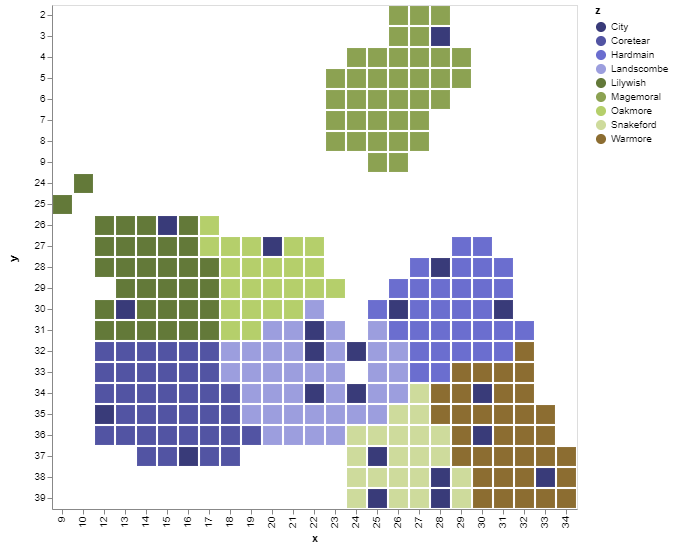

In [37]:
draw.drawboarders(world.df_features)

# The age of the Conflict

The terrain and all of the natural features are formed in the first age. Cities and nations in the second. In the third age chaos will shift the natural order and cause the tension that creates the objectives of the game. 


In [38]:
town = world.towns[1]
print(f"{town.name} is loyal to the nation of {town.nation}")
print(f"{town.diplomacy}")

Foundersbridge is loyal to the nation of Hardmain
{'nation': 'Hardmain', 'national fealty': 1}


People have loyalty to thier nations, as well as towns. Nations have a loyalty to each other. Towns have speakers, who represent the town. Nations have rulers. 

In [39]:
example_nation = world.nations[1]
print (example_nation.ruler," has a temperment of ",example_nation.ruler.temperment)
print (example_nation.get_capitol().speaker," has a loyalty of ",example_nation.get_capitol().speaker.loyalty)

Alontel the Ruler of the nation of Hardmain  has a temperment of  0.46
Sazennend the Speaker of Foundersbridge  has a loyalty of  0.5


In [40]:
world.get_filtered_chord(t=['plain','mountain','forrest'],n=example_nation.name,r='key')

'31:32'

In [41]:
example_nation.towns

[capitol of Foundersbridge: population: 5 location: [28,28] founded 0,
 town of Starplace: population: 2 location: [26,30] founded 6,
 town of Helljaw: population: 1 location: [31,30] founded 7]

## Swaying favor with other nations

Events cause the relationship to sway between nations. This can be done by passing the `nation` or list of `nation` objects into the `alter_favor` function. 

In [42]:
nations.treaties

,stance,favor
0,sworn enemies,0.0
1,war,0.1
2,tense,0.3
3,peace,0.6
4,allies,0.9


Altering the favor of a nation is a complicated function. 

In [43]:
help(nations.alter_favor)

Help on function alter_favor in module lib.builders.nations:

alter_favor(s, o, a)
    s = the target nation(s) (obj or list). s will not change. O's favor of s will change.
    o = the nation(s) (obj or list) who's favor is change. O's favor of s will change
    
    Examples:
    (a,[o]) each nation in o's favor of a is changed by s
    (a,o) o's favor of a is changed by s
    ([a],o) o's favor of each nation in a is changed by s
    s = amount of change (int)
    
    national relationship with itself doesn't decay, but town and person loyalty can.



### example 1: one nation does something that many other nations's don't like. 

In [44]:
s_nation = world.nations[0]
o_nations = world.nations[1:3]
affect = -.25
nations.alter_favor(s_nation,o_nations,affect)

In [45]:
print("subject nations (nations who have done the deed)")
print(f"{s_nation} did something {affect} to {o_nations}")
print(s_nation,"\n",yaml.dump(s_nation.diplomacy))

print("object nations (nations who's favor is affected by the deed)")
[print(j,"\n",yaml.dump(j.diplomacy)) for j in o_nations]


subject nations (nations who have done the deed)
Nation of Coretear did something -0.25 to [Nation of Hardmain, Nation of Magemoral]
Nation of Coretear 
 Hardmain:
  favor: 0.8
  stance: peace
Landscombe:
  favor: 0.8
  stance: peace
Lilywish:
  favor: 0.8
  stance: peace
Magemoral:
  favor: 0.8
  stance: peace
Oakmore:
  favor: 0.8
  stance: peace
Snakeford:
  favor: 0.8
  stance: peace
Warmore:
  favor: 0.8
  stance: peace

object nations (nations who's favor is affected by the deed)
Nation of Hardmain 
 Coretear:
  favor: 0.55
  stance: tense
Landscombe:
  favor: 0.8
  stance: peace
Lilywish:
  favor: 0.8
  stance: peace
Magemoral:
  favor: 0.8
  stance: peace
Oakmore:
  favor: 0.8
  stance: peace
Snakeford:
  favor: 0.8
  stance: peace
Warmore:
  favor: 0.8
  stance: peace

Nation of Magemoral 
 Coretear:
  favor: 0.55
  stance: tense
Hardmain:
  favor: 0.8
  stance: peace
Landscombe:
  favor: 0.8
  stance: peace
Lilywish:
  favor: 0.8
  stance: peace
Oakmore:
  favor: 0.8
  stance

[None, None]

### example 2: several nations does something that annother nation likes. 

In [46]:
s_nations = world.nations[2:4]
o_nation = world.nations[5]
affect = .25

nations.alter_favor(s_nations,o_nation,affect)

In [47]:
print("subject nations (nations who have done the deed)")
print(f"{s_nations} did something {affect} to {o_nation}")
[print(j,"\n",yaml.dump(j.diplomacy)) for j in s_nations]
print("object nations (nations who's favor is affected by the deed)")
print(o_nation,"\n",yaml.dump(o_nation.diplomacy))

subject nations (nations who have done the deed)
[Nation of Magemoral, Nation of Snakeford] did something 0.25 to Nation of Landscombe
Nation of Magemoral 
 Coretear:
  favor: 0.55
  stance: tense
Hardmain:
  favor: 0.8
  stance: peace
Landscombe:
  favor: 0.8
  stance: peace
Lilywish:
  favor: 0.8
  stance: peace
Oakmore:
  favor: 0.8
  stance: peace
Snakeford:
  favor: 0.8
  stance: peace
Warmore:
  favor: 0.8
  stance: peace

Nation of Snakeford 
 Coretear:
  favor: 0.8
  stance: peace
Hardmain:
  favor: 0.8
  stance: peace
Landscombe:
  favor: 0.8
  stance: peace
Lilywish:
  favor: 0.8
  stance: peace
Magemoral:
  favor: 0.8
  stance: peace
Oakmore:
  favor: 0.8
  stance: peace
Warmore:
  favor: 0.8
  stance: peace

object nations (nations who's favor is affected by the deed)
Nation of Landscombe 
 Coretear:
  favor: 0.8
  stance: peace
Hardmain:
  favor: 0.8
  stance: peace
Lilywish:
  favor: 0.8
  stance: peace
Magemoral:
  favor: 1
  stance: allies
Oakmore:
  favor: 0.8
  stance

Events are thier own thing. They aren't `culture` or `landscape`. They happen at the beginning of the game and depending on `culture.chaos` happen when the character moves from area to area. 

In [48]:
e = events.get_possible_events()
e

['bandits', 'marrage', 'raiders', 'temple']

 `culture.eons` determines how many years will pass with a possibility of an event happening. `culture.chaos` determines how likely an event is to occur.

In [49]:
world.culture.eons,world.culture.chaos

(10, 0.6)

In [51]:
#now to run through the eons and let fate happen
all_events = events.pass_through_time(world)
all_events

['great_hall']
['great_hall']
['great_hall']
['great_hall']


['0: bandits have set up camp in the None of [Nation of Hardmain]',
 '1: bandits have set up camp in the None of [Nation of Lilywish]',
 '2: nothing happend during this period.',
 '3: a great temple was founded in the city of Lionhollow in [Nation of Magemoral]',
 '4: a great temple was founded in the city of Starhost in [Nation of Snakeford]',
 '5: bandits have set up camp in the None of [Nation of Landscombe]',
 '6: a great temple was founded in the city of Badgerfold in [Nation of Oakmore]',
 '7: nothing happend during this period.',
 '8: a noble from [Nation of Lilywish] was married to a noble in [Nation of Warmore]',
 '9: a great temple was founded in the city of Heirmark in [Nation of Warmore]']

# Monsters and Enemies

In [ ]:
world.culture.chaos

In [ ]:
world = events.add_chaos_to_world(world)

alt.Chart(world.df_features).mark_bar().encode(
    alt.X("danger", bin=True),
    y='count()',
)

# Saving the local copy

Saving a local copy of the pickled file for update. TODO: add function to save pickle in S3

In [ ]:
world.df_features.head(10)

In [ ]:
with open('world.p', 'wb') as pickle_file:
    pickle.dump(world, pickle_file)